In [6]:
import netket as nk
import numpy as np
import os
import jax
from netket.operator.spin import sigmax,sigmaz 
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [3]:
N = 20
hi = nk.hilbert.Spin(s=1 / 2, N=N)

In [5]:
hi.random_state(jax.random.key(0), 3)

Array([[ 1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  1.,  1., -1., -1.],
       [ 1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,
         1.,  1.,  1., -1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
         1.,  1.,  1., -1.,  1., -1.,  1.]], dtype=float32)

In [7]:
Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

## ED sanity check

In [12]:
from scipy.sparse.linalg import eigsh

sp_h=H.to_sparse()
sp_h.shape

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

(1048576, 1048576)

## Mean-field ansatz

In [14]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

In [15]:
# Create an instance of the model. 
# Notice that this does not create the parameters, but only the specification of how the model is constructed and acts upon inputs/.
mf_model = MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=512)

In [17]:
E = vstate.expect(H)
print(E)

-19.80 ± 0.20 [σ²=19.72, R̂=1.0126]


## DIY learning VMC

In [18]:
from tqdm import tqdm

energy_history = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_util.tree_map(lambda x,y: x-0.05*y, vstate.parameters, E_grad)
    # actually update the parameters
    vstate.parameters = new_pars

100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


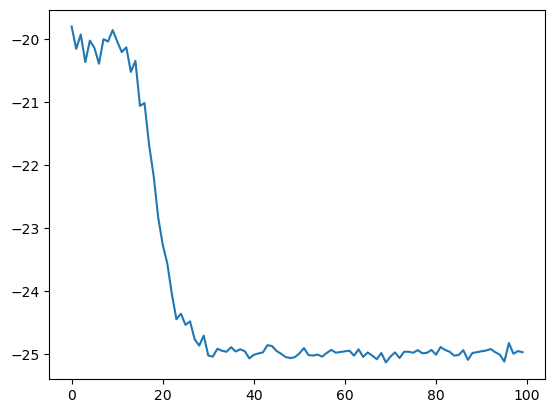

In [19]:
import matplotlib.pyplot as plt

plt.plot(energy_history)

## Netket optimizer

In [20]:
# First we reset the parameters to run the optimisation again
vstate.init_parameters()

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

mf_energy=vstate.expect(H)
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

  0%|          | 0/300 [00:00<?, ?it/s]

Optimized energy and relative error:  -24.984 ± 0.048 [σ²=1.167, R̂=1.0200] 0.019888414782338278


## Jastrow Ansatz

In [21]:
class JasShort(nn.Module):
    @nn.compact
    def __call__(self, x):
        
        # Define the two variational parameters J1 and J2
        j1 = self.param(
            "j1", nn.initializers.normal(), (1,), float
        )
        j2 =self.param(
            "j2", nn.initializers.normal(), (1,), float
        )

        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(j1*corr1+j2*corr2,axis=-1)
    
model=JasShort()

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

In [22]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

# construct the logger
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

print(f"Final optimized parameters: j1={vstate.parameters['j1']}, j2={vstate.parameters['j2']}")

jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error}")

  0%|          | 0/300 [00:00<?, ?it/s]

Final optimized parameters: j1=[0.23439731], j2=[0.0805861]
Optimized energy : -25.312 ± 0.019 [σ²=0.368, R̂=1.0117]
relative error   : 0.007040766508702985


In [23]:
data_jastrow = log.data
print(data_jastrow)

{'acceptance': History(
   keys  = ['value'], 
   iters = [0, 1, ... 298, 299] (300 steps),
), 'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


Text(0, 0.5, 'Energy')

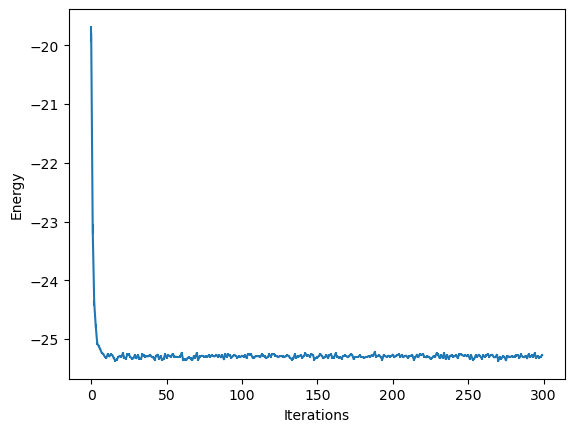

In [24]:
from matplotlib import pyplot as plt

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma)
plt.xlabel('Iterations')
plt.ylabel('Energy')

## NN ground state

In [31]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
                
        # sum the output
        return jnp.sum(y, axis=-1)
    
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

In [26]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",ffn_energy,error)

  0%|          | 0/300 [00:00<?, ?it/s]

Optimized energy and relative error:  -25.472 ± 0.012 [σ²=0.153, R̂=1.0170] 0.0007478534233720952


Text(0, 0.5, 'Energy')

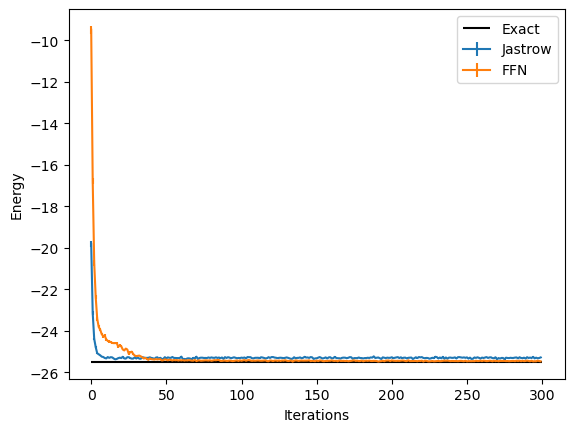

In [27]:
data_FFN = log.data

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma, label="Jastrow")
plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

## Translation symmetry

In [28]:
graph=nk.graph.Chain(length=N, pbc=True)

print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9]), Translation([10]), Translation([11]), Translation([12]), Translation([13]), Translation([14]), Translation([15]), Translation([16]), Translation([17]), Translation([18]), Translation([19])], degree=20)


In [29]:
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

In [33]:
import flax.linen as nn
import netket.nn as nknn

class SymmModel(nn.Module):
    alpha: int

    @nn.compact
    def __call__(self, x):
        # add an extra dimension with size 1, because DenseSymm requires rank-3 tensors as inputs.
        # the shape will now be (batches, 1, Nsites)
        x = x.reshape(-1, 1, x.shape[-1])
        
        x = nknn.DenseSymm(symmetries=graph.translation_group(),
                           features=self.alpha,
                           kernel_init=nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))


sampler = nk.sampler.MetropolisLocal(hi)

#Let us define a model with 4 features per symmetry
model=SymmModel(alpha=4)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

vstate.n_parameters

84

In [34]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=600,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)

  0%|          | 0/600 [00:00<?, ?it/s]

Optimized energy and relative error:  -25.4916 ± 0.0014 [σ²=0.0020, R̂=1.0125] 2.4049599556750333e-05


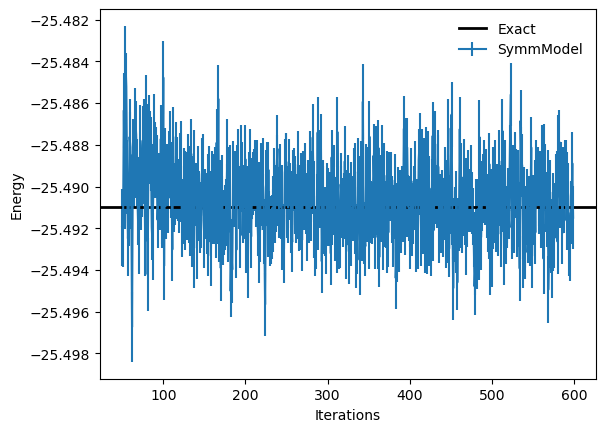

In [35]:
plt.errorbar(log.data["Energy"].iters[50:],log.data["Energy"].Mean[50:],yerr=log.data["Energy"].Sigma[50:],label="SymmModel")

plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## The x-x correlation function

In [36]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])
vstate.n_samples=400000
vstate.expect(corr)

10.906 ± 0.018 [σ²=31.514, R̂=1.0002]

In [37]:
psi = eig_vecs[:, 0]
exact_corr=psi@(corr@psi)
print(exact_corr)

10.852248713127695
